In [93]:
import retinanalysis as ra
import numpy as np
from typing import List
import matplotlib.pyplot as plt

## Step 1: Query protocol across all experiments

In [2]:
protocols_to_query = ['movingletters', 'presentmatfiles']
experiment_query = ra.get_datasets_from_protocol_names(protocols_to_query)
display(experiment_query)


Found 1 protocols matching "movingletters":
['edu.washington.riekelab.protocols.MovingLetters']

Found 1 protocols matching "presentmatfiles":
['edu.washington.riekelab.protocols.PresentMatFiles']

Found 5 experiments, 10 epoch blocks.



,exp_name,datafile_name,NDF,chunk_name,protocol_name,is_mea,data_dir,group_label,experiment_id,protocol_id,group_id,block_id,chunk_id
0,20250429C,data007,0.5,moving_letters,edu.washington.riekelab.protocols.MovingLetters,1,20250429C/data007,DR moving letters,122,67,2250,3265,476
1,20250429C,data009,0.5,moving_letters,edu.washington.riekelab.protocols.MovingLetters,1,20250429C/data009,DR moving letters,122,67,2252,3267,476
2,20250514C,data003,0.5,movies_images,edu.washington.riekelab.protocols.PresentMatFiles,1,20250514C/data003,PresentMatFiles,124,68,2277,3298,488
3,20250514C,data015,0.5,moving_letters,edu.washington.riekelab.protocols.MovingLetters,1,20250514C/data015,DR Moving Letters,124,67,2289,3310,490
4,20250527C,data010,0.5,moving_letters,edu.washington.riekelab.protocols.MovingLetters,1,20250527C/data010,Moving E,125,67,2299,3322,497
5,20250530C,data002,0.5,moving_letters,edu.washington.riekelab.protocols.MovingLetters,1,20250530C/data002,Moving Letters,127,67,2316,3340,510
6,20250715C,data003,0.5,letters1,edu.washington.riekelab.protocols.MovingLetters,1,20250715C/data003,moving letters,130,67,2340,3374,530
7,20250715C,data008,0.5,defocus,edu.washington.riekelab.protocols.PresentMatFiles,1,20250715C/data008,DLR Defocus No Gap Half Run,130,68,2345,3379,527
8,20250715C,data009,0.5,defocus,edu.washington.riekelab.protocols.PresentMatFiles,1,20250715C/data009,DLR Defocus Default,130,68,2346,3380,527
9,20250715C,data012,0.5,letters2,edu.washington.riekelab.protocols.MovingLetters,1,20250715C/data012,moving letters,130,67,2349,3383,532


## Select experiment and data file of interest

In [3]:
exp_name = experiment_query.loc[2, 'exp_name']
datafile_name = experiment_query.loc[2,'datafile_name']
ls_param_names = ['magnificationFactor', 'matFile', 'imageOrder']
pipeline=ra.create_mea_pipeline(exp_name, datafile_name, ls_params = ls_param_names)
stim = pipeline.stim_block
response = pipeline.response_block
analysis = pipeline.analysis_chunk

Initializing StimBlock for 20250514C block 3298
Nearest noise chunk for data003 is chunk1 with distance 20 minutes.

Initializing ResponseBlock for 20250514C block 3298
Loading frame monitor data from /Volumes/ExternalM2/mea_ssd/data/h5/20250514C.h5 ...
Loaded (500, 3500) frame_data.

Loading VCD from /Volumes/ExternalM2/mea_ssd/data/sorted/20250514C/data003/kilosort2.5 ...
VCD loaded with 884 cells.

Using chunk1 for AnalysisChunk

Loading VCD from /Volumes/ExternalM2/mea_ssd/analysis/20250514C/chunk1/kilosort2.5 ...
VCD loaded with 781 cells.

Loaded spatial maps for channels [0, 2] and 781 cells of shape (127, 203, 2)
Spatial maps have been padded to align with RF parameters.

Cluster matching 20250514C chunk1 with PresentMatFiles ...
64.15% matched, 35.85% unmatched.



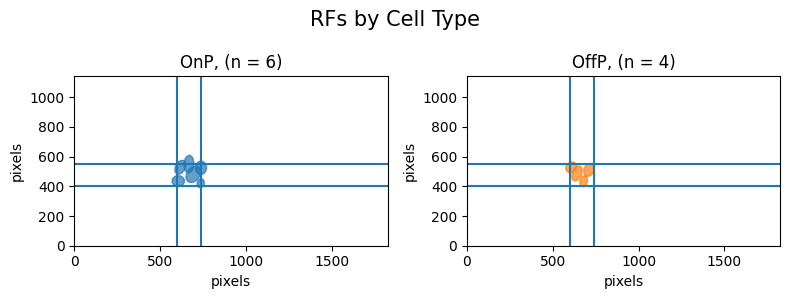

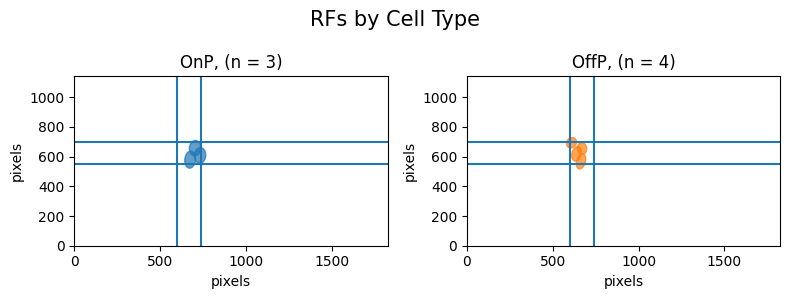

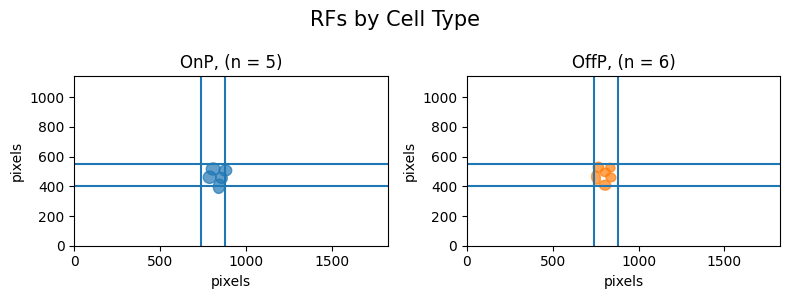

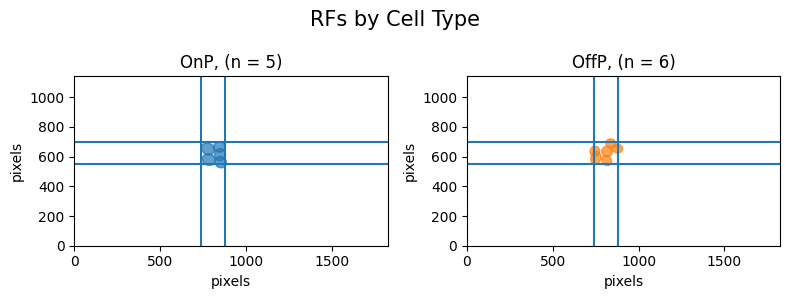

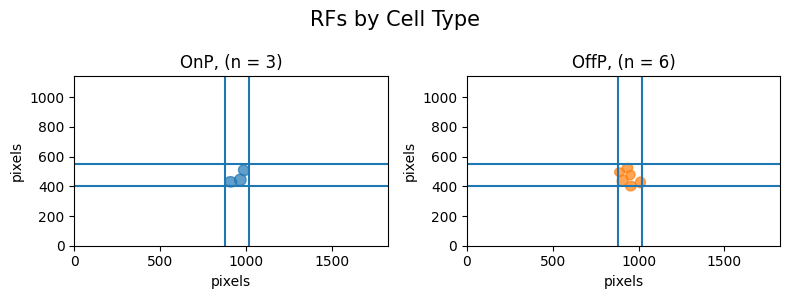

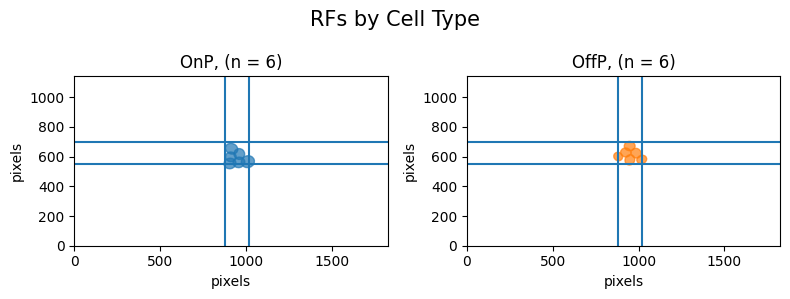

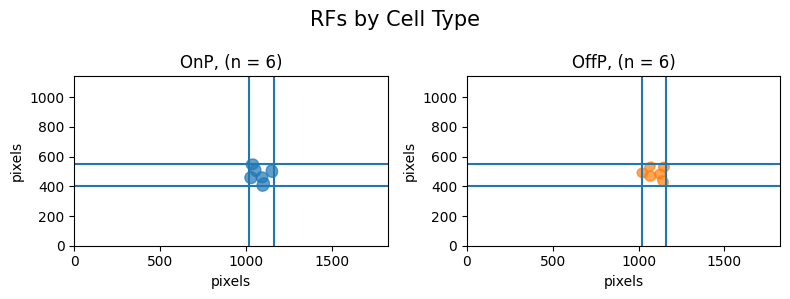

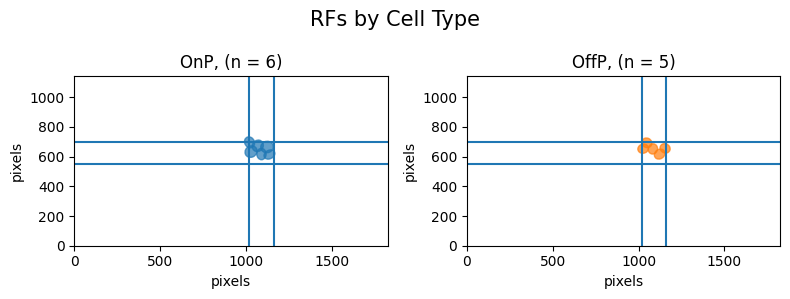

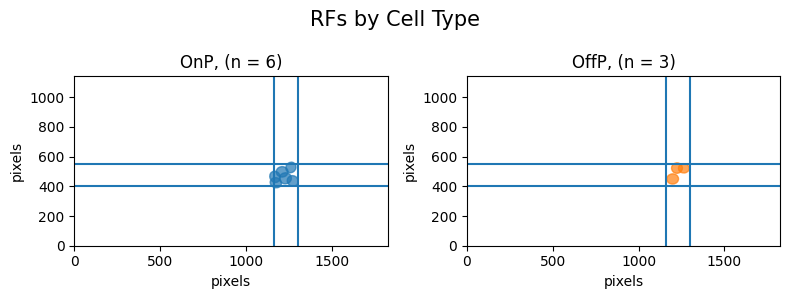

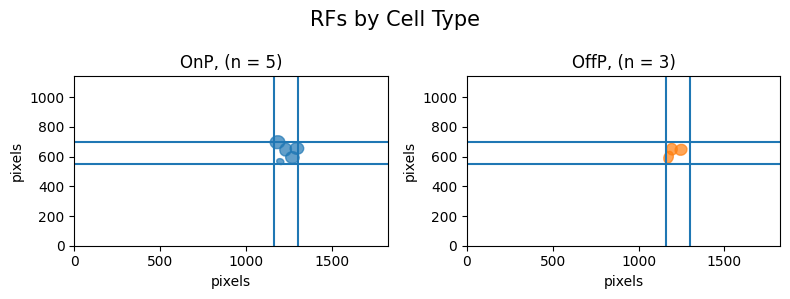

In [ ]:
cell_types = ['OnP', 'OffP']

def make_roi_grid(x_min: int = 600, x_max: int = 1300,
                  y_min: int = 400, y_max: int = 700,
                  x_steps: int = 6, y_steps: int = 4):

    xvals = np.linspace(x_min, x_max, x_steps, dtype = int)
    yvals = np.linspace(y_min, y_max, y_steps, dtype = int)

    roi_dicts = []
    for x_idx in range(len(xvals)-1):
        for y_idx in range(len(yvals)-1):
            roi_dicts.append({'x_min' : xvals[x_idx], 'x_max' : xvals[x_idx+1], 'y_min' : yvals[y_idx], 'y_max' : yvals[y_idx+1]})

    return roi_dicts

dict_out = make_roi_grid(x_steps = 6, y_steps = 3)

def get_roi_grid_ids(roi_dicts: List[dict], cell_types: List[str], mea_pipeline: ra.MEAPipeline):
    d_roi_ids = dict()
    for idx, d in enumerate(roi_dicts):
        rf_axes = mea_pipeline.plot_rfs(cell_types = cell_types, units = 'pixels', roi = d)
        for ax in rf_axes:
            ax.axvline(d['x_min'])
            ax.axvline(d['x_max'])
            ax.axhline(d['y_min'])
            ax.axhline(d['y_max'])
        d_pull_ids = dict()
        for ct in cell_types:
            all_ids = mea_pipeline.get_cells_by_region(roi = d)
            ct_ids = mea_pipeline.response_block.df_spike_times.query('cell_type == @ct and cell_id in @all_ids')['cell_id'].values
            d_pull_ids[ct] = ct_ids
        d_roi_ids[idx] = d_pull_ids
        
    return d_roi_ids

d_roi_ids = get_roi_grid_ids(dict_out, cell_types = cell_types, mea_pipeline = pipeline)

# rf_axes = pipeline.plot_rfs(cell_types = cell_types, units = 'pixels', roi = roi_dict)
# timecourse_axes = pipeline.plot_timecourses(cell_types = cell_types, roi = roi_dict, roi_units = 'pixels');

In [ ]:
epoch_params = ['imageOrder']
image_order = [lst for lst in stim.df_epochs['imageOrder']]
image_order = np.array(image_order)

images_per_epoch = stim.df_epochs.loc[0,'epoch_parameters']['imagesPerEpoch']
num_epochs = len(stim.df_epochs)